Press 'q' to stop detection.

0: 384x640 (no detections), 739.1ms
Speed: 7.0ms preprocess, 739.1ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 1054.8ms
Speed: 99.2ms preprocess, 1054.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 257.3ms
Speed: 51.9ms preprocess, 257.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Other Traffic signs, 1 Cars, 239.9ms
Speed: 8.0ms preprocess, 239.9ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Other Traffic signs, 3 Carss, 233.9ms
Speed: 4.0ms preprocess, 233.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Other Traffic signs, 6 Carss, 275.8ms
Speed: 5.0ms preprocess, 275.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Other Traffic signs, 6 Carss, 255.8ms
Speed: 4.0ms preprocess, 255.8ms inference, 3.0ms postprocess

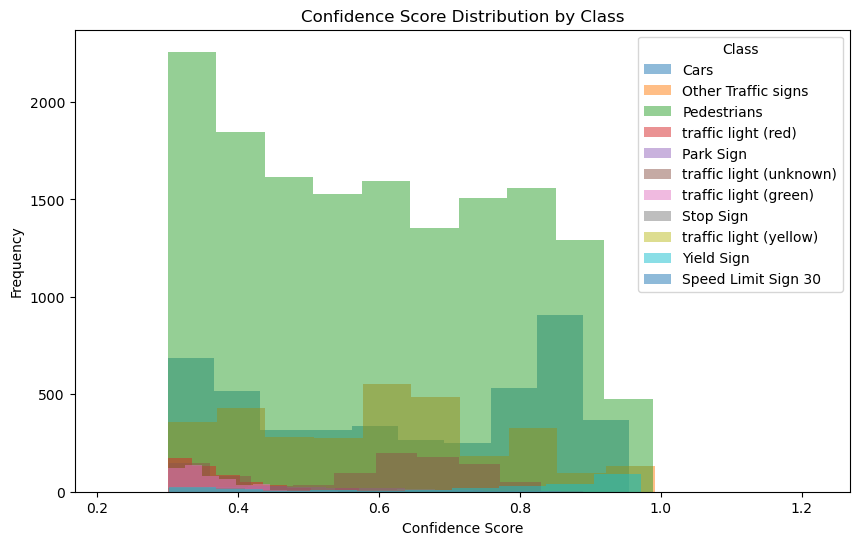

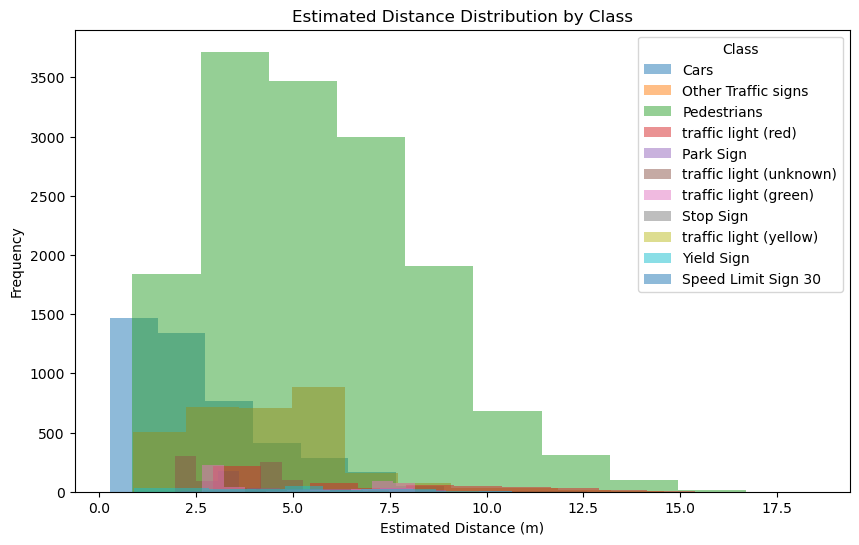

In [8]:
#!pip install opencv-python
#!pip install ultralytics


# Necessary imports
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from copy import deepcopy

# Fix OpenMP runtime issue
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Load YOLO Model
def load_yolo_model(model_path=r"C:\Users\USER\Documents\UofC\Fall 2024\ENGG 680\Project\Traffic Sign\Traffic Sign\Traffic-sign-detection-using-yolo\runs\detect\train9\weights\last.pt"):
    """
    Load YOLO model from the specified path.
    """
    model = YOLO(model_path)
    return model

model = load_yolo_model()

# Class labels (adjust as necessary)
class_labels = {
    0: 'Speed Limit Sign 30', 1: 'Speed Limit Sign 50', 2: 'Yield Sign', 3:'Stop Sign', 4: 'Other Traffic signs', 5:'Cars', 6:'Pedestrians', 7: 'traffic light', 8: 'Park Sign'
    # Add more if necessary
}

# Function to process detections
def process_detections(result, confidence_threshold=0.5):
    """
    Process and filter detections based on a confidence threshold and exclude 'Unknown' classes.
    """
    filtered_detections = []
    for box in result.boxes:
        if box.conf >= confidence_threshold:
            class_id = int(box.cls)
            class_name = class_labels.get(class_id, 'Unknown')
            
            # Skip 'Unknown' labels
            if class_name == 'Unknown':
                continue
            
            # Add valid detections to the filtered list
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = float(box.conf)
            filtered_detections.append({
                'box': (x1, y1, x2, y2),
                'confidence': confidence,
                'label': class_name
            })
    return filtered_detections


# Function to annotate frames
def annotate_frame(frame, detections):
    for det in detections:
        x1, y1, x2, y2 = det['box']
        label = f"{det['label']} {det['confidence']:.2f}"
        color = (0, 255, 0) if det['confidence'] > 0.5 else (0, 0, 255)  # Red for low confidence
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return frame

# Distance estimation function
def estimate_distance(detections, focal_length=554, real_object_width=0.5):
    for det in detections:
        bbox_width = det['box'][2] - det['box'][0]
        estimated_distance = (focal_length * real_object_width) / bbox_width if bbox_width != 0 else float('inf')
        det['distance'] = estimated_distance
    return detections

# Log and save data to CSV
def extract_detection_data(detections):
    data = []
    for det in detections:
        x1, y1, x2, y2 = det['box']
        label = det['label']
        confidence = det['confidence']
        distance = det.get('distance', None)
        data.append({'label': label, 'confidence': confidence, 'distance': distance, 'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2})
    return data

def save_detection_data_to_csv(detection_data, filename='detection_log.csv'):
    df = pd.DataFrame(detection_data)
    df.to_csv(filename, index=False)
    print(f"Detection data saved to {filename}")

# Plotting results
def plot_classwise_statistics(log_file):
    """Plot class-wise confidence and distance distributions."""
    import pandas as pd
    import matplotlib.pyplot as plt

    # Load the log data
    df = pd.read_csv(log_file)

    # Plot confidence score distribution per class
    plt.figure(figsize=(10, 6))
    for label in df['label'].unique():
        subset = df[df['label'] == label]
        plt.hist(subset['confidence'], bins=10, alpha=0.5, label=label)
    plt.title('Confidence Score Distribution by Class')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.legend(title="Class")
    plt.show()

    # Plot distance distribution per class
    plt.figure(figsize=(10, 6))
    for label in df['label'].unique():
        subset = df[df['label'] == label]
        plt.hist(subset['distance'], bins=10, alpha=0.5, label=label)
    plt.title('Estimated Distance Distribution by Class')
    plt.xlabel('Estimated Distance (m)')
    plt.ylabel('Frequency')
    plt.legend(title="Class")
    plt.show()

# Function to analyze traffic light color
def detect_traffic_light_color(frame, bbox):
    """
    Detect the color in the traffic light bounding box.
    Parameters:
        frame: The video frame containing the detected traffic light.
        bbox: Bounding box (x1, y1, x2, y2) for the traffic light.
    Returns:
        color: A string ('red', 'yellow', 'green') based on the detected light color.
    """
    x1, y1, x2, y2 = bbox
    traffic_light = frame[y1:y2, x1:x2]

    # Convert to HSV color space to easily identify colors
    hsv = cv2.cvtColor(traffic_light, cv2.COLOR_BGR2HSV)
    
    # Define HSV ranges for red, yellow, and green colors
    red_lower = np.array([0, 70, 50])
    red_upper = np.array([10, 255, 255])
    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])
    green_lower = np.array([40, 50, 50])
    green_upper = np.array([90, 255, 255])

    # Create masks for each color
    red_mask = cv2.inRange(hsv, red_lower, red_upper)
    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
    green_mask = cv2.inRange(hsv, green_lower, green_upper)

    # Count the number of pixels in each color mask
    red_count = cv2.countNonZero(red_mask)
    yellow_count = cv2.countNonZero(yellow_mask)
    green_count = cv2.countNonZero(green_mask)

    # Determine the color with the most pixels
    if red_count > yellow_count and red_count > green_count:
        return "red"
    elif yellow_count > red_count and yellow_count > green_count:
        return "yellow"
    elif green_count > red_count and green_count > yellow_count:
        return "green"
    else:
        return "unknown"

# Update process_detections to include traffic light color checking
def process_detections(result, frame, confidence_threshold=0.5):
    """
    Process and filter detections based on a confidence threshold and determine traffic light color.
    """
    filtered_detections = []
    for box in result.boxes:
        if box.conf >= confidence_threshold:
            class_id = int(box.cls)
            class_name = class_labels.get(class_id, 'Unknown')
            
            # Skip 'Unknown' labels
            if class_name == 'Unknown':
                continue
            
            # Add valid detections to the filtered list
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = float(box.conf)
            
            # If traffic light detected, analyze the color
            if class_name == 'traffic light':
                light_color = detect_traffic_light_color(frame, (x1, y1, x2, y2))
                if light_color == 'red' or light_color == 'yellow':
                    recommendation = "STOP"
                elif light_color == 'green':
                    recommendation = "GO"
                else:
                    recommendation = "UNKNOWN"

                # Display recommendation
                cv2.putText(frame, f"{recommendation}", (x1, y2 + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255) if recommendation == "STOP" else (0, 255, 0), 2)
                
                # Add color information to the detection
                filtered_detections.append({
                    'box': (x1, y1, x2, y2),
                    'confidence': confidence,
                    'label': f"{class_name} ({light_color})"
                })
            else:
                filtered_detections.append({
                    'box': (x1, y1, x2, y2),
                    'confidence': confidence,
                    'label': class_name
                })
    return filtered_detections

# Update run_detection_with_video to pass frame to process_detections
def run_detection_with_video(model, video_path, confidence_threshold=0.3, log_file='detection_log.csv'):
    cap = cv2.VideoCapture(video_path)  # Load the video file
    all_detections = []
    print("Press 'q' to stop detection.")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Perform detection
        results = model(frame)
        result = results[0]

        # Process detections and estimate distances
        detections = process_detections(result, frame, confidence_threshold)
        detections = estimate_distance(detections)

        # Annotate and display frame
        annotated_frame = annotate_frame(frame, detections)
        cv2.imshow('Video Object Detection', annotated_frame)

        # Log detection data
        frame_data = extract_detection_data(detections)
        all_detections.extend(frame_data)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    save_detection_data_to_csv(all_detections, log_file)
    plot_classwise_statistics(log_file)

# Run the updated function with the video file path
video_path = r"C:\Users\USER\Videos\4K Video Downloader+\A Car and Cobbled Streets   Driving in Prague [4K HDR].mp4"
run_detection_with_video(model, video_path)
